In [1]:
import pandas as pd
import numpy as np
import Preprocess
import pydicom
import matplotlib.pyplot as plt
import cv2
import os
from keras.models import model_from_json
import keras


Using TensorFlow backend.


In [2]:
# !pip install keras

In [3]:
path = '../'
preprocess = Preprocess.Preprocess(path)

In [4]:
labels = preprocess.label_set('stage_1_train.csv', 0, 120000)
labels.head(6)

,ID,Label,Sub_type,PatientID
361025,ID_000039fa0_any,0,any,000039fa0
361020,ID_000039fa0_epidural,0,epidural,000039fa0
361021,ID_000039fa0_intraparenchymal,0,intraparenchymal,000039fa0
361022,ID_000039fa0_intraventricular,0,intraventricular,000039fa0
361023,ID_000039fa0_subarachnoid,0,subarachnoid,000039fa0
361024,ID_000039fa0_subdural,0,subdural,000039fa0


In [5]:
training_labels = labels['Label']
len(training_labels)

120000

In [6]:
training_labels = np.array(training_labels)
training_labels = preprocess.categorize(training_labels)
len(training_labels)

20000

In [7]:
path_dcmFiles = path + '/stage_1_train_images/*.dcm'
dcm_files = Preprocess.Preprocess.read_dcm_files(path_dcmFiles)
len(dcm_files)

20000

In [8]:
desired_size = (128, 128)
buff_size = 20000

converted_training_imgs = []

for i in range(0, buff_size, 1):
    dcm_data = pydicom.dcmread(dcm_files[i])
    temp = preprocess.resizing(dcm_data, desired_size)
    converted_training_imgs.append(temp)
    

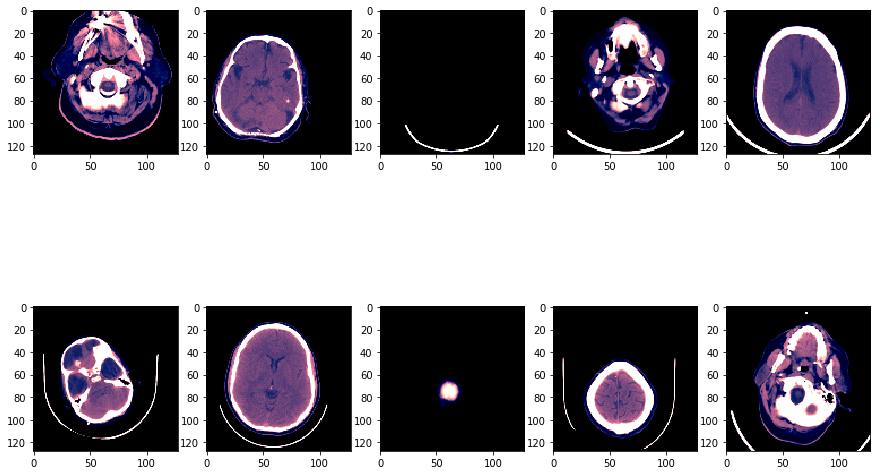

In [9]:
fig=plt.figure(figsize=(15,10))
columns = 5; rows = 2
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(converted_training_imgs[i], cmap=plt.cm.bone)

In [10]:
training_imgs = preprocess.transform_all_pixel_arrays(converted_training_imgs)

del converted_training_imgs

# convert a list 'training_imges' into a numpy array
training_imgs = np.array(training_imgs)

In [11]:
# convert a list 'training_label'into a numpy array
training_labels = np.array(training_labels)

In [12]:
training_imgs = training_imgs.reshape(20000, 128, 128, 3)

In [14]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [ ]:
model.fit(training_imgs, training_labels, epochs=2, validation_split=0.1, shuffle=True)

## Save the model and weights

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open(path + "model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(path + "model.h5")
print("Saved model to disk")

Saved model to disk


## Load json and create model

In [17]:
# later when I want to load json and create model
json_file = open(path + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)


## Load weights into a new model

In [19]:
# load weights into new model
loaded_model.load_weights(path + "model.h5")
print("Loaded model from disk")

Loaded model from disk
